In [1]:
%load_ext autoreload
%autoreload 2

# Returns of each stock

In [2]:
from library.dataset import get_prices, get_log_returns

# Load returns
df_returns = get_log_returns(get_prices())
tickers = df_returns.columns

Chosen tickers: ['LKOH', 'SBERP', 'VTBR', 'SBER', 'MOEX']
Length before dropping NaNs: 2603
Length after dropping NaNs: 2577


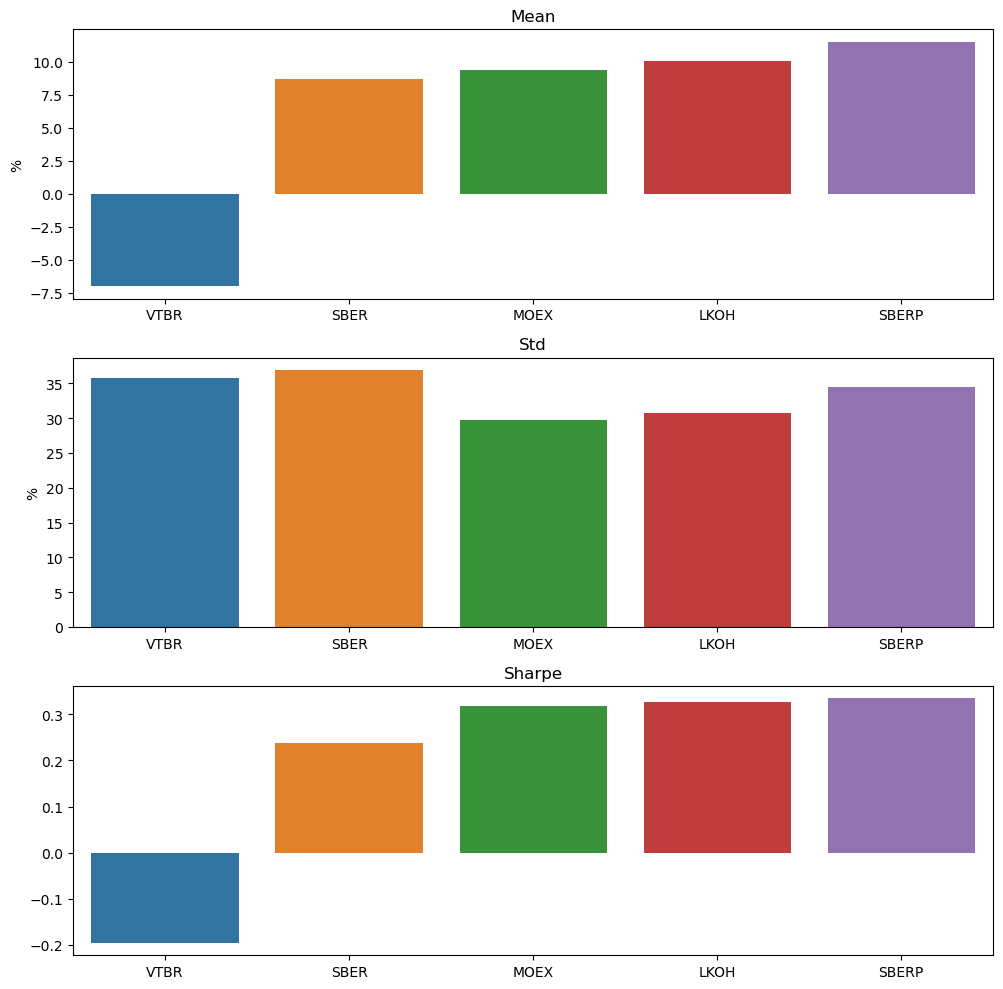

In [3]:
from library.portfolio import plot_tickers_performance

plot_tickers_performance(df_returns)

# Returns correlation matrix

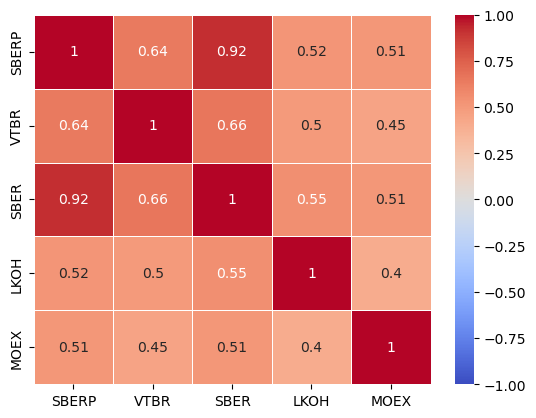

In [4]:
from library.correlations import plot_correlation_matrix

sorted_tickers = plot_correlation_matrix(df_returns.corr())

# Equal portfolio

Annual Return (mean ± std): 6.7% ± 27.3%
Sharpe: 0.24

Annual Mean Return 95% confidence interval: 6.66%±16.74%


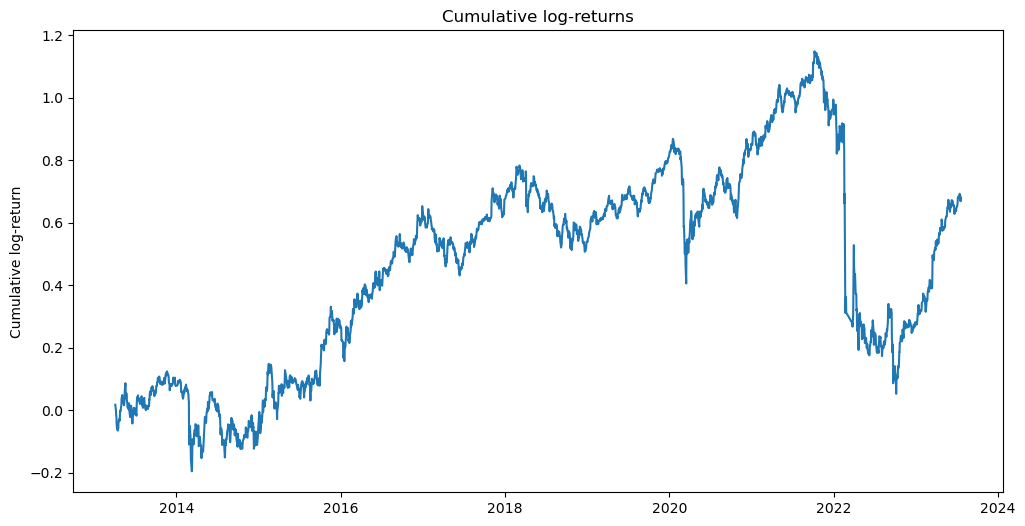

In [5]:
from library.portfolio import print_statistics
from library.momentum import get_equal_portfolio

print_statistics(get_equal_portfolio(df_returns.columns), df_returns)

# Momentum portfolio

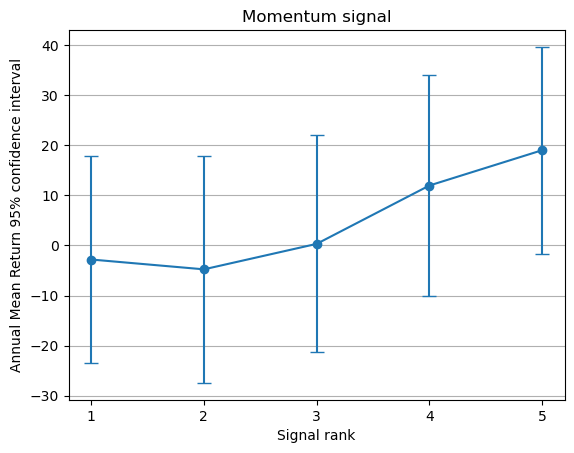

In [6]:
from library.momentum import get_momentum_signal, plot_signal_ranks

df_momentum_signal = get_momentum_signal(df_returns, from_n_days=365, to_n_days=20, from_min_periods=180, to_min_periods=10)
plot_signal_ranks(df_momentum_signal, df_returns, 'Momentum signal')

Annual Return (mean ± std): 10.8% ± 28.4%
Sharpe: 0.38

Annual Mean Return 95% confidence interval: 10.78%±18.12%


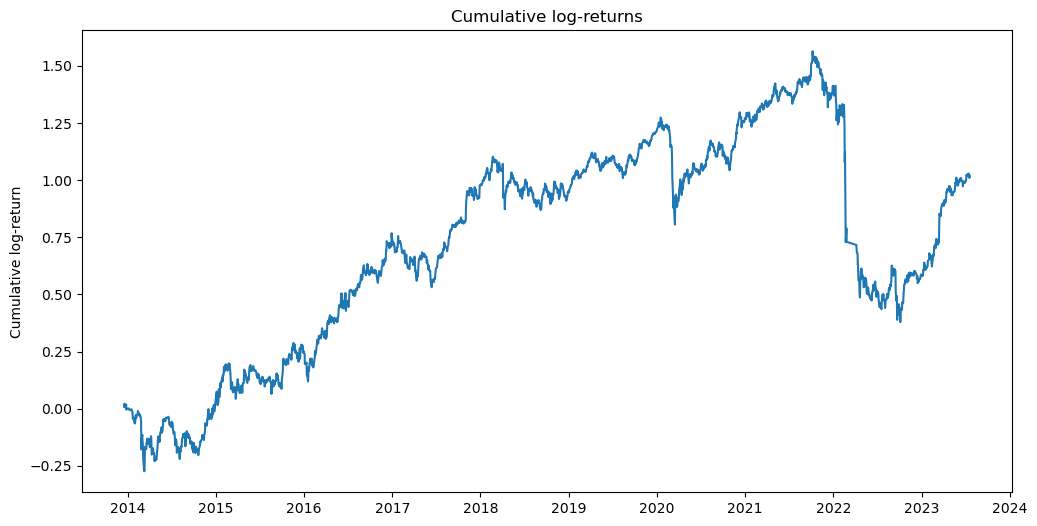

In [7]:
from library.momentum import get_portfolio_from_signal

df_momentum_weights = get_portfolio_from_signal(df_momentum_signal)
print_statistics(df_momentum_weights, df_returns)

# Markowitz portfolio